# Temporal EAV patient graphs

In [1]:
import os
import sys
from datetime import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm as tqdm
import networkx as nx
import torch
from torch_geometric.data import HeteroData


In [2]:
from src.constants import *

In [4]:
# repo import
sys.path.append('../../')
# Import internal functions
from src.data.process.patient_dataset import build_patient_sample,\
                                             load_hf_data_and_metadata


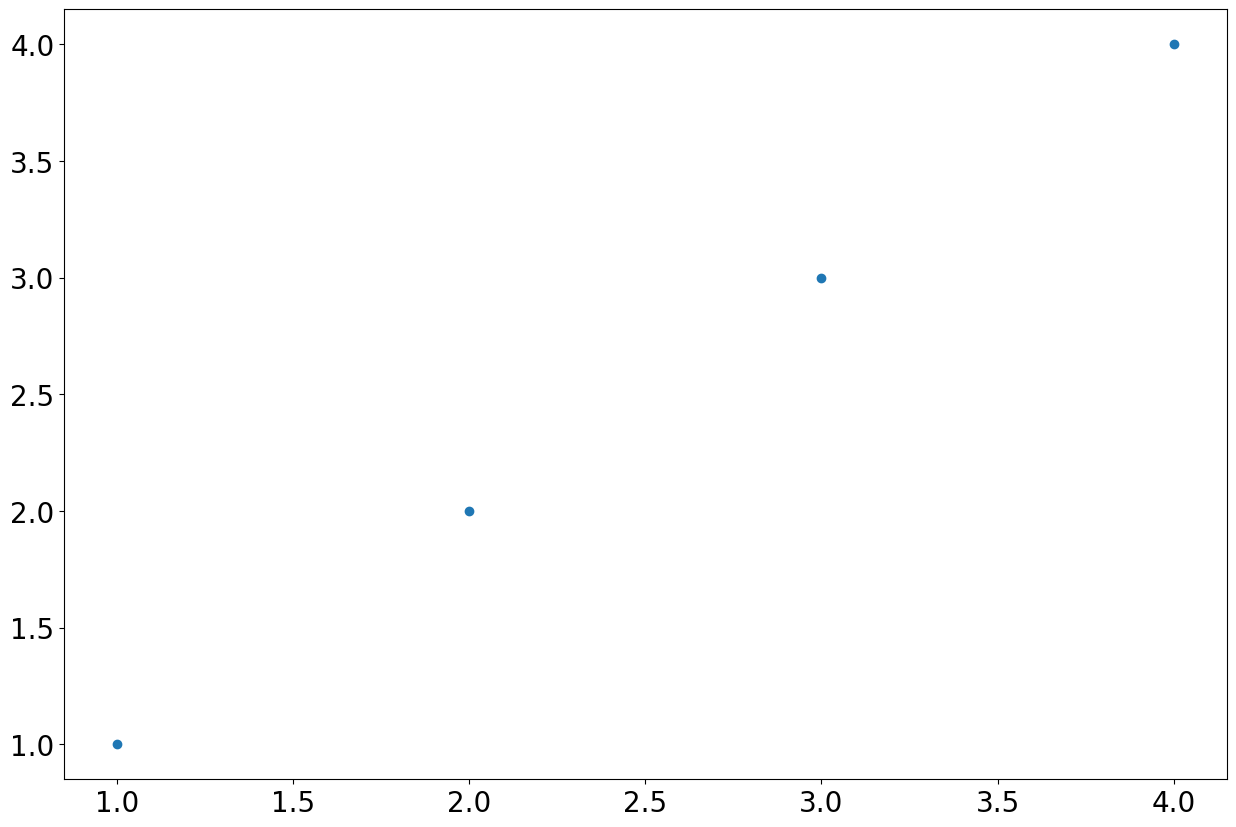

In [5]:
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (10, 5) # To increase the size of the plots
#mpl.rcParams['figure.figsize'] = (20, 10) # To increase the size of the plots
mpl.rcParams['figure.figsize'] = (15, 10) # To increase the size of the plots
#mpl.rcParams['figure.figsize'] = (20, 15) # To increase the size of the plots

#======================================================================#
#======================================================================#
# Defining the plot
params = {'axes.labelsize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'axes.titlesize': 20}
plt.rcParams.update(params)
axisTickSize = 40
    
# Dummy plot
plt.scatter(x=[1, 2, 3, 4], y=[1, 2, 3, 4])
plt.show()

# I) Load data one patient

## A) Raw data

In [6]:
# Pre-processed data folder
preprocessed_folder = "/home/vindasya/Baobab/Codes/aiidkit/data/preprocessed/"

# Selecting one patient file
patient_ID = "80000189"
patient_file = preprocessed_folder + f"patient_{patient_ID}.csv"

# Loading the file as a pandas dataframe
#df_pat = pd.read_csv(patient_file)

# Getting the infection events
#inf_events_pat = get_all_infection_events(df_pat)

In [7]:
# Process the CSV to get the data of the patient using Alban's and Melanie's code
# IMPORTANT: the output, pat_dict, is a dict having the following keys: 'entity', 'attribute', 'value', 'time', 'days_since_tpx', 'infection_events', 'patient_csv_path'
# IMPORTANT: pat_dict[key] is a list containing the values of the different rows of the patients CSV files.
# IMPORTANT: All static features (age of donnor, warm ischemia time, etc.) have the 'days_since_tpx' 0, which is the time when the transplant 
# IMPORTANT: occured. Therefore, all measurements that happened before the transplant will have a negative 'days_since_tpx'.
# IMPORTANT: The 'days_since_tpx' variable is in days.
pat_dict = build_patient_sample(patient_file)
print(f"\n ===> Keys of pat_dict: {list(pat_dict.keys())}\n")


 ===> Keys of pat_dict: ['entity', 'attribute', 'value', 'time', 'days_since_tpx', 'infection_events', 'patient_csv_path']



In [8]:
# Inspecting some data
# EAV values
tmp_ID = 0
for tmp_key in ['entity', 'attribute', 'value', 'time', 'days_since_tpx']:
    print(f"\n ===> {tmp_key}: {pat_dict[tmp_key][tmp_ID]}")
# Infection events
for inf_event_ID in range(len(pat_dict['infection_events']['infection_time'])):
    inf_event_time_since_tpx = pat_dict['infection_events']['infection_time'][inf_event_ID]
    inf_event_type = pat_dict['infection_events']['infection_type'][inf_event_ID]
    print(f"\n\t===> Infection event {inf_event_time_since_tpx} days after transplantation: {inf_event_type}")


 ===> entity: Receiver baseline lab results

 ===> attribute: HDL chol. level [mmol/L]

 ===> value: 1.27

 ===> time: 2006-03-13

 ===> days_since_tpx: -784

	===> Infection event 310 days after transplantation: Bacterial Infection


## B) Hugging face dataset creation with cutoffs days and different forecast horizons

In [9]:
# Loading a dataset
huggingface_dir_path = "/home/vindasya/Baobab/Codes/aiidkit/data/hf_data/"
metadata_dir_path = "/home/vindasya/Baobab/Codes/aiidkit/data/hf_metadata/"
prediction_horizon = 30
cutoff_days_train = [30, 90]
cutoff_days_valid = [30, 90]
pats_dataset, bin_intervals, vocabs = load_hf_data_and_metadata(
                                                                    data_dir=huggingface_dir_path,
                                                                    metadata_dir=metadata_dir_path,
                                                                    prediction_horizon=prediction_horizon,
                                                                    cutoff_days_train=cutoff_days_train,
                                                                    cutoff_days_valid=cutoff_days_valid,
                                                                )

## C) Heterogeneous graph creation WITH Networkx

In [10]:
# Selecting one training patient
tmp_pat_ID = 0

# Getting patient data
pat_data_dict = {}
for tmp_key in list(pats_dataset["train"].features.keys()):
    pat_data_dict[tmp_key] = pats_dataset["train"][tmp_key][tmp_pat_ID]

In [11]:
# Regrouping patient data by date
pat_data_dict_regrouped = {}
for i in range(pat_data_dict['entity'].shape[0]):
    time = pat_data_dict['time'][i]
    if (time.lower() != 'nan'):
        if (pat_data_dict['time'][i] not in pat_data_dict_regrouped):
            pat_data_dict_regrouped[time] = []
        node = {
                    "entity": pat_data_dict['entity'][i],
                    "attribute": pat_data_dict['attribute'][i],
                    "days_since_tpx": pat_data_dict['days_since_tpx'][i],
                    "value": pat_data_dict['value'][i],
                    "time": pat_data_dict['time'][i]
               }
        pat_data_dict_regrouped[time].append(node)

In [12]:
def date_difference_in_days(date_str1, date_str2):
    """
    Computes the difference in days between two date strings (YYYY-MM-DD).

    Parameters:
    -----------
        date_str1: str
            The first date string.
        date_str2: str
            The second date string.

    Returns:
    -----------
        time_diff: int
            The difference in days.
    """
    # Define the expected format
    date_format = "%Y-%m-%d"

    # Convert the strings to datetime objects
    date1 = datetime.strptime(date_str1, date_format)
    date2 = datetime.strptime(date_str2, date_format)

    # Compute the difference (a timedelta object)
    time_difference = date2 - date1

    # Extract the total number of days from the timedelta object
    time_diff = time_difference.days 
    
    return time_diff

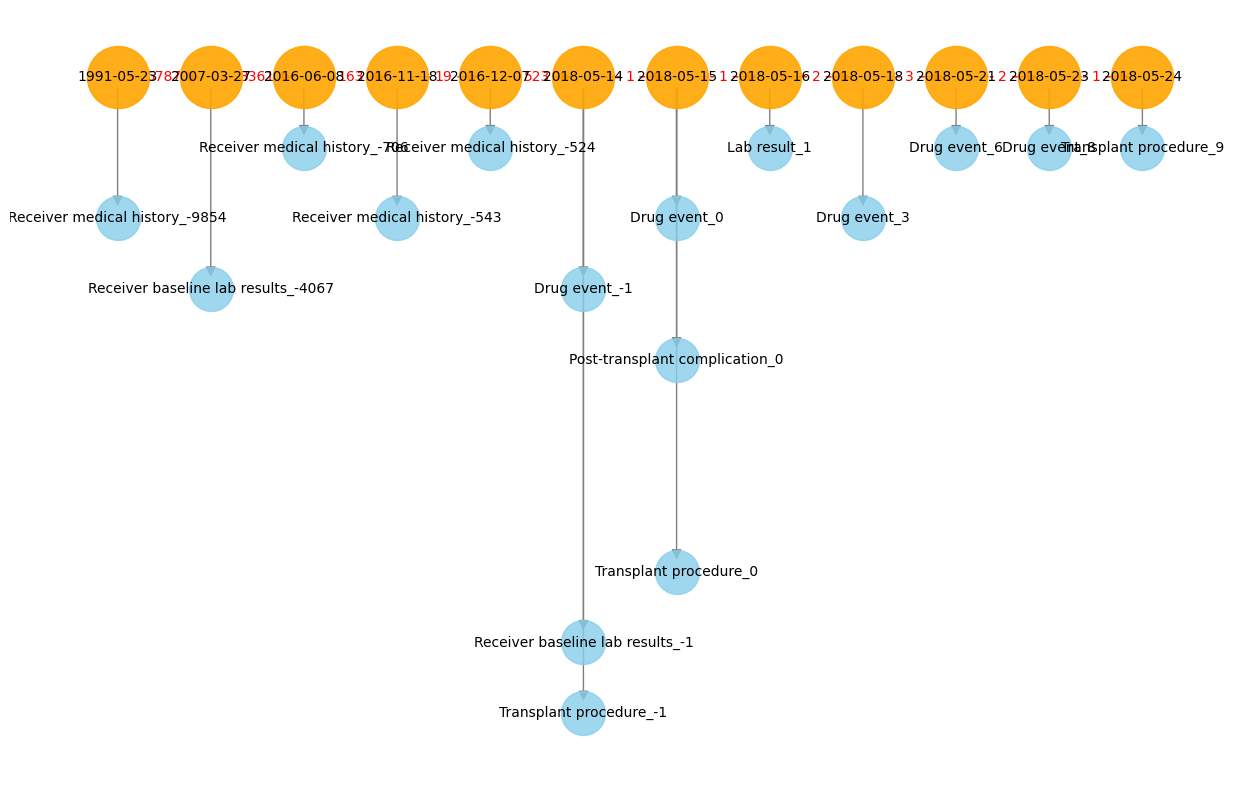

In [13]:
# Create directed graph
G = nx.DiGraph()

# Define central nodes (sequence)
central_nodes = list(pat_data_dict_regrouped.keys())
for c in central_nodes:
    G.add_node(c, ntype="central")

# Add sequence edges between central nodes with attributes
for i in range(len(central_nodes) - 1):
    time_diff_days = date_difference_in_days(central_nodes[i], central_nodes[i + 1])
    G.add_edge(central_nodes[i], central_nodes[i + 1], etype="sequence", label=str(time_diff_days))

# Add children
children = {}
for central_node in central_nodes:
    if central_node not in children:
        children[central_node] = []
    for child in pat_data_dict_regrouped[central_node]:
        children[central_node].append(child['entity'] + f"_{child['days_since_tpx']}")

for parent, kids in children.items():
    for k in kids:
        G.add_node(k, ntype="child")
        # Child edges get a different type
        G.add_edge(parent, k, etype="child_link")

# Layout
pos = {}
for i, c in enumerate(central_nodes):
    pos[c] = (i, 0)
    for j, k in enumerate(children.get(c, [])):
        pos[k] = (i, -(j+1))

# Separate by node type
central_nodes_list = [n for n, d in G.nodes(data=True) if d["ntype"] == "central"]
child_nodes_list   = [n for n, d in G.nodes(data=True) if d["ntype"] == "child"]

# Separate edges by type
sequence_edges = [(u, v) for u, v, d in G.edges(data=True) if d["etype"] == "sequence"]
child_edges    = [(u, v) for u, v, d in G.edges(data=True) if d["etype"] == "child_link"]

# Draw nodes
plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, nodelist=central_nodes_list,
                       node_color="orange", node_size=2000, alpha=0.9)
nx.draw_networkx_nodes(G, pos, nodelist=child_nodes_list,
                       node_color="skyblue", node_size=1000, alpha=0.8)

# Draw edges differently
nx.draw_networkx_edges(G, pos, edgelist=sequence_edges,
                       edge_color="red", style="dashed", arrows=True, arrowstyle="-|>", arrowsize=15)
nx.draw_networkx_edges(G, pos, edgelist=child_edges,
                       edge_color="gray", arrows=True, arrowstyle="-|>", arrowsize=15)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Draw edge labels for central sequence
edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True) if "label" in d}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.axis("off")
plt.show()


# II) Nodes and edges creations for Pytorch Geometric

In practice, in Pytorch Geometric, for each node, we need features. We are going to work with heterogeneous graphs:
- Two type of nodes:
    - Central nodes: indicating the time at which the measurement was done.
    - Child nodes: indicating the different features measured at that day. Here, we represent each child node as a tuple, identified by its entity, attribute, value, and time in days post transplant. For each entity–attribute pair (both categorical and continuous), we construct a dedicated embedding. All entity–attribute pairs share a common embedding layer. To incorporate temporal information, we add a positional embedding that encodes time. For numerical attributes, the pre-processed value is concatenated with the embedding. For categorical attributes, we create a separate embedding layer for each entity–attribute possible values, multiply the resulting embedding by a learnable weight tensor, and add the resulting embedding to the previously obtained representation.
- Two types edges:
    - Edges between central nodes: having as weight the time difference in days between the two measurements.
    - Edges between central nodes and child nodes: no weight.

**IMPORTANT**: To treat the case where new values appear for categorical values, we add an "unknown value" token to each entity-attribute possible values per, to map any new value seen to this token.


In [14]:
# Getting all the possible values for each pair Entity-Attribute in the DS
# USE ONLY TRAIN dataset
possible_values_all_patients = {}
for data_split in ['train']:
#for data_split in tqdm(pats_dataset):
    entity = pats_dataset[data_split]['entity']
    attribute = pats_dataset[data_split]['attribute']
    value = pats_dataset[data_split]['value']
    times = pats_dataset[data_split]['time']
    for pat_ID in tqdm(range(entity.shape[0])):
        n_vals = entity[pat_ID].shape[0]
        for i in range(n_vals):
        #for i in tqdm(range(n_vals)):
            # Get EAV
            ent = entity[pat_ID][i]
            attr = attribute[pat_ID][i]
            val = value[pat_ID][i]
            time = times[pat_ID][i]
            # Add to dict of entity-attribute values
            if ((ent, attr) not in possible_values_all_patients):
                possible_values_all_patients[(ent, attr)] = set()
            possible_values_all_patients[(ent, attr)].add(val)


  0%|          | 0/3740 [00:00<?, ?it/s]

In [15]:
# Function indicating if a str is a float encoded as a string or a real string
def is_float_string(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [16]:
# Separate numerical variables from continuous ones
categorical_ent_attr_pairs = {}
continuous_ent_attr_pairs = {}
for ent, attr in possible_values_all_patients:
    # Test if continuous: if all possible values are floats
    are_all_floats = True
    for val in possible_values_all_patients[(ent, attr)]:
        # Test if float
        is_float = is_float_string(val)
        if (not is_float):
            are_all_floats = False
            break
    # Separating
    if (are_all_floats):
        continuous_ent_attr_pairs[(ent, attr)] = possible_values_all_patients[(ent, attr)]
    else:
        categorical_ent_attr_pairs[(ent, attr)] = possible_values_all_patients[(ent, attr)]
        
# Number of continuous and categorical entity-attr pairs
print(f"\n===> Number of entity-attr pairs with continuous values: {len(continuous_ent_attr_pairs)}")
print(f"\n===> Number of entity-attr pairs with categorical values: {len(categorical_ent_attr_pairs)}")


===> Number of entity-attr pairs with continuous values: 39

===> Number of entity-attr pairs with categorical values: 120


In [17]:
# Number of possible values per categorical variables
for ent_attr_pair in categorical_ent_attr_pairs:
    print(f"\n===>For entity-attribute {ent_attr_pair} there are {len(categorical_ent_attr_pairs[ent_attr_pair])} possible values\n")
    #if (len(categorical_ent_attr_pairs[ent_attr_pair]) > 30):
        #print(f"\t=======>{ent_attr_pair}: {categorical_ent_attr_pairs[ent_attr_pair]}\n\n")


===>For entity-attribute ('Receiver medical history', 'Etiology histology') there are 3 possible values


===>For entity-attribute ('Receiver medical history', 'MEK diagnosis') there are 11 possible values


===>For entity-attribute ('Receiver medical history', 'Any other diagnosis') there are 11 possible values


===>For entity-attribute ('Receiver medical history', 'Etiology') there are 13 possible values


===>For entity-attribute ('Receiver medical history', 'Initial dialysis type') there are 2 possible values


===>For entity-attribute ('Drug event', 'Drug start') there are 87 possible values


===>For entity-attribute ('Receiver baseline lab results', 'Glucose test result') there are 4 possible values


===>For entity-attribute ('Receiver baseline lab results', 'HBA1C test result') there are 3 possible values


===>For entity-attribute ('Transplant procedure', 'Hospitalization') there are 2 possible values


===>For entity-attribute ('Post-transplant complication', 'DGF') there 

In [18]:
# Getting the number of categories for each categorical pair Entity-Attribute
n_categorical_per_ent_attr_pair = {}
n_var_one_category = 0
for ent, attr in categorical_ent_attr_pairs:
    n_categorical_per_ent_attr_pair[(ent, attr)] = len(categorical_ent_attr_pairs[(ent, attr)])
    if (n_categorical_per_ent_attr_pair[(ent, attr)] == 1):
        print(f"Entity-Attribute pair ({ent}, {attr}) has the {n_categorical_per_ent_attr_pair[(ent, attr)]} possible values: {categorical_ent_attr_pairs[(ent, attr)]}\n")
        n_var_one_category += 1
print(f"\n\n=========>A total of {n_var_one_category} samples only have one category")

Entity-Attribute pair (Post-transplant complication, DGF) has the 1 possible values: {'No'}

Entity-Attribute pair (Parasitic Infection, Clinically significant) has the 1 possible values: {'False'}

Entity-Attribute pair (Parasitic Infection, Donor related infection) has the 1 possible values: {'NO'}

Entity-Attribute pair (Parasitic Infection, Pathogens Parasitic primary infection) has the 1 possible values: {'0: Primary infection'}



=========>A total of 4 samples only have one category


# III) Create Pytorch Geometric Dataset

### A) Create a graph for each patient

In [19]:
# Create IDs for all the entity-attribute pairs
possible_ent_attr_pairs = list(possible_values_all_patients)
ids_ent_attr_pairs = {possible_ent_attr_pairs[i]: i for i in range(len(possible_ent_attr_pairs))}
inv_ids_ent_attr_pairs = {ids_ent_attr_pairs[ent_attr_pair]: ent_attr_pair for ent_attr_pair in ids_ent_attr_pairs}

# Create embedding layer
emb_dim_ent_attr = 8
ent_attr_pair_emb_layer = torch.nn.Embedding(len(inv_ids_ent_attr_pairs), emb_dim_ent_attr)  # one embedding per entity-attr pair

In [20]:
# Creating embedding layers for categorical values for entity-attribute pairs
categorical_vals_vocabs = {}
categorical_vals_emb_layers = {}
emb_dim_ent_attr_vals = 8
for ent, attr in categorical_ent_attr_pairs:
    # Remove Unknown if exists
    categorical_ent_attr_pairs[(ent, attr)].discard('Unknown')
    categorical_ent_attr_pairs[(ent, attr)].discard('unknown')
    # Add Unknown token <UNK>
    categorical_ent_attr_pairs[(ent, attr)].add('<UNK>')
    categorical_vals_vocabs[(ent, attr)] = {value: index for index, value in enumerate(categorical_ent_attr_pairs[(ent, attr)])}
    categorical_vals_emb_layers[(ent, attr)] = torch.nn.Embedding(len(categorical_vals_vocabs[(ent, attr)]), emb_dim_ent_attr_vals)
    

In [21]:
def positional_encoding(pos, d):
    """
        Generates sinusoidal positional encoding for a given position/time
        
        Parameters:
        -----------
        pos: int or torch.tensor of shape [num_nodes]
            Time (int) used to generate the positional embedding        
        d: intr
            Embedding dimension

        Returns:
        --------
        pe: torch.tensor
            Embedding tensor
    """
    if (type(pos) == torch.Tensor):
        pe = torch.zeros(len(pos), d)
    else:
        pos = torch.tensor(pos)
        pe = torch.zeros(1, d)
    for k in range(d):
        if k % 2 == 0: # Even k = 2*i
            div_term = 10000 ** (k / d)
            pe[:, k] = torch.sin(pos / div_term)
        else: # Odd k = 2*i+1
            div_term = 10000 ** ((k-1) / d)
            pe[:, k] = torch.cos(pos / div_term)
    return pe



In [127]:
def build_hetero_graph_with_embeddings(
                                        pat_data_dict_regrouped,
                                        ids_ent_attr_pairs,
                                        continuous_ent_attr_pairs,
                                        categorical_ent_attr_pairs,
                                        categorical_vals_emb_layers,
                                        ent_attr_pair_emb_layer
                                      ):
    """
        Returns a Pytorch Geometric heterogeneous data representing
        the patient trajectory.

        Parameters:
        -----------
        pat_data_dict_regrouped: dict
            Dictionary regrouping the patient's features by date 
            (the keys are the times of measurments of patient
            information).
        ids_ent_attr_pairs: dict
            Dictionary giving unique IDs to pairs (entity, attribute),
            necessary to use embeddings. The keys are (entity, attribute)
            pairs and the values are the IDs.
        continuous_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having continuous (float) values.
        categorical_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having categorical values.
        categorical_vals_emb_layers: dict
            Dictionary of nn.Embedding layers where the keys are 
            list of the form (entity, attribute) and the values
            are the nn.Embedding layers.
        ent_attr_pair_emb_layer: nn.Embedding
            Embedding layer for (entity, attribute) pairs.

        Returns:
        --------
        pat_data_graph: HeteroData
            Heterogeneous graph representing the patient's trajectory.
    """
    # Creating graph Pytorch Geometric structure for patient
    pat_data_graph = HeteroData()
    
    # Central nodes (time feature only, float)
    central_nodes = torch.from_numpy(np.unique([int(pat_data_dict_regrouped[key][i]['days_since_tpx']) for key in pat_data_dict_regrouped for i in range(len(pat_data_dict_regrouped[key]))]).reshape(-1, 1))
    pat_data_graph["central"].x = central_nodes
    
    # Child nodes IDs and values
    children_ent_attr_continuous_ids = []
    children_ent_attr_continuous_values = []
    children_ent_attr_continuous_times = []
    children_ent_attr_continuous_days_since_tpx = []
    children_ent_attr_categorical_ids = []
    children_ent_attr_categorical_values = []
    children_ent_attr_categorical_times = []
    children_ent_attr_categorical_days_since_tpx = []
    for day in pat_data_dict_regrouped:
        n_childs = len(pat_data_dict_regrouped[day])
        for child_local_ID in range(n_childs):
            # Getting the child entity-attribute ID
            child = pat_data_dict_regrouped[day][child_local_ID]
            ent_attr_pair = (child['entity'], child['attribute'])
            id_ent_attr_pair = ids_ent_attr_pairs[ent_attr_pair]
    
            # Getting the value
            if (ent_attr_pair in continuous_ent_attr_pairs):
                children_ent_attr_continuous_ids.append(id_ent_attr_pair)
                children_ent_attr_continuous_values.append(float(child['value']))
                children_ent_attr_continuous_times.append(child['time'])
                children_ent_attr_continuous_days_since_tpx.append(child['days_since_tpx'])
            elif (ent_attr_pair in categorical_ent_attr_pairs):
                children_ent_attr_categorical_ids.append(id_ent_attr_pair)
                children_ent_attr_categorical_values.append([ent_attr_pair, child['value']])
                children_ent_attr_categorical_times.append(child['time'])
                children_ent_attr_categorical_days_since_tpx.append(child['days_since_tpx'])
    
                
    children_ent_attr_continuous_ids = torch.tensor(children_ent_attr_continuous_ids)
    children_ent_attr_continuous_values = torch.tensor(children_ent_attr_continuous_values)
    children_ent_attr_continuous_days_since_tpx = torch.tensor(children_ent_attr_continuous_days_since_tpx)
    children_ent_attr_categorical_ids = torch.tensor(children_ent_attr_categorical_ids)
    children_ent_attr_categorical_emb = torch.stack([categorical_vals_emb_layers[c[0]](torch.tensor(categorical_vals_vocabs[c[0]].get(c[1], categorical_vals_vocabs[c[0]]["<UNK>"]))) for c in children_ent_attr_categorical_values])
    children_ent_attr_categorical_days_since_tpx = torch.tensor(children_ent_attr_categorical_days_since_tpx)
    
    # Child node features
    # Continuous
    ent_attr_pair_cont_emb = ent_attr_pair_emb_layer(children_ent_attr_continuous_ids)
    ent_attr_pair_cont_emb = torch.cat([ent_attr_pair_cont_emb, children_ent_attr_continuous_values.unsqueeze(-1)], dim=-1)
    pos_enc_cont_emb = positional_encoding(pos=children_ent_attr_continuous_days_since_tpx, d=ent_attr_pair_cont_emb.shape[1])
    child_cont_features = ent_attr_pair_cont_emb + pos_enc_cont_emb
    pat_data_graph['child_cont'].x = child_cont_features
    
    # Categorical
    ent_attr_pair_categ_emb = ent_attr_pair_emb_layer(children_ent_attr_categorical_ids)
    ent_attr_pair_categ_emb = ent_attr_pair_categ_emb + children_ent_attr_categorical_emb
    pos_enc_categ_emb = positional_encoding(pos=children_ent_attr_categorical_days_since_tpx, d=ent_attr_pair_categ_emb.shape[1])
    child_categ_features = ent_attr_pair_categ_emb + pos_enc_categ_emb
    pat_data_graph['child_categ'].x = child_categ_features
    
    # Create the edges
    # Between central nodes
    central_nodes_edge_idx = torch.tensor([ [i for i in range(len(central_nodes)-1)], [j for j in range(1, len(central_nodes))]])
    central_nodes_times = [key for key in pat_data_dict_regrouped]
    edges_central_nodes_edge_attr = torch.tensor([date_difference_in_days(central_nodes_times[i], central_nodes_times[i+1]) for i in range(len(central_nodes_times)-1)]).unsqueeze(1)
    pat_data_graph["central", "sequence", "central"].edge_index = central_nodes_edge_idx
    pat_data_graph["central", "sequence", "central"].edge_attr = edges_central_nodes_edge_attr
    # Between central nodes and child nodes
    central_to_child_cont_edge_idx = [[], []]
    central_to_child_categ_edge_idx = [[], []]
    for central_node_i in range(central_nodes.shape[0]):
        time_central_node = central_nodes_times[central_node_i]
        # Continuous nodes
        for child_cont_j in range(len(children_ent_attr_continuous_times)):
            time_child_cont = children_ent_attr_continuous_times[child_cont_j]
            if (time_central_node == time_child_cont):
                central_to_child_cont_edge_idx[0].append(central_node_i)
                central_to_child_cont_edge_idx[1].append(child_cont_j)
        # Categorical nodes
        for child_categ_j in range(len(children_ent_attr_categorical_times)):
            time_child_categ = children_ent_attr_categorical_times[child_categ_j]
            if (time_central_node == time_child_categ):
                central_to_child_categ_edge_idx[0].append(central_node_i)
                central_to_child_categ_edge_idx[1].append(child_categ_j)
    central_to_child_cont_edge_idx = torch.tensor(central_to_child_cont_edge_idx)
    central_to_child_categ_edge_idx = torch.tensor(central_to_child_categ_edge_idx)
    pat_data_graph["central", "has_child", "child_cont"].edge_index = central_to_child_cont_edge_idx
    pat_data_graph["central", "has_child", "child_categ"].edge_index = central_to_child_categ_edge_idx

    return pat_data_graph
    
# Test
pat_data_graph = build_hetero_graph_with_embeddings(
                                                        pat_data_dict_regrouped=pat_data_dict_regrouped,
                                                        ids_ent_attr_pairs=ids_ent_attr_pairs,
                                                        continuous_ent_attr_pairs=continuous_ent_attr_pairs,
                                                        categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                                        categorical_vals_emb_layers=categorical_vals_emb_layers,
                                                        ent_attr_pair_emb_layer=ent_attr_pair_emb_layer
                                                      )

In [64]:
# Plot graph
def hetero_to_networkx(data: HeteroData):
    G = nx.DiGraph()

    # Add central nodes
    for i, feat in enumerate(data["central"].x):
        G.add_node(f"C{i}", type="central", feature=feat.item())

    # Add child nodes
    try:
        for i, feat in enumerate(data["child_cont"].x):
            G.add_node(f"H{i}", type="child_cont")
        for i, feat in enumerate(data["child_categ"].x):
            G.add_node(f"H{i}", type="child_categ")
    except:
        for i, feat in enumerate(data["child_cont"].ids):
            G.add_node(f"H{i}", type="child_cont")
        for i, feat in enumerate(data["child_categ"].ids):
            G.add_node(f"H{i}", type="child_categ")

    # Add edges (central -> central)
    src, dst = data["central", "sequence", "central"].edge_index
    for s, d in zip(src.tolist(), dst.tolist()):
        G.add_edge(f"C{s}", f"C{d}", type="sequence")

    # Add edges (central -> child)
    src, dst = data["central", "has_child", "child_cont"].edge_index
    for s, d in zip(src.tolist(), dst.tolist()):
        G.add_edge(f"C{s}", f"H{d}", type="child_cont")
    src, dst = data["central", "has_child", "child_categ"].edge_index
    for s, d in zip(src.tolist(), dst.tolist()):
        G.add_edge(f"C{s}", f"H{d}", type="child_categ")

    return G

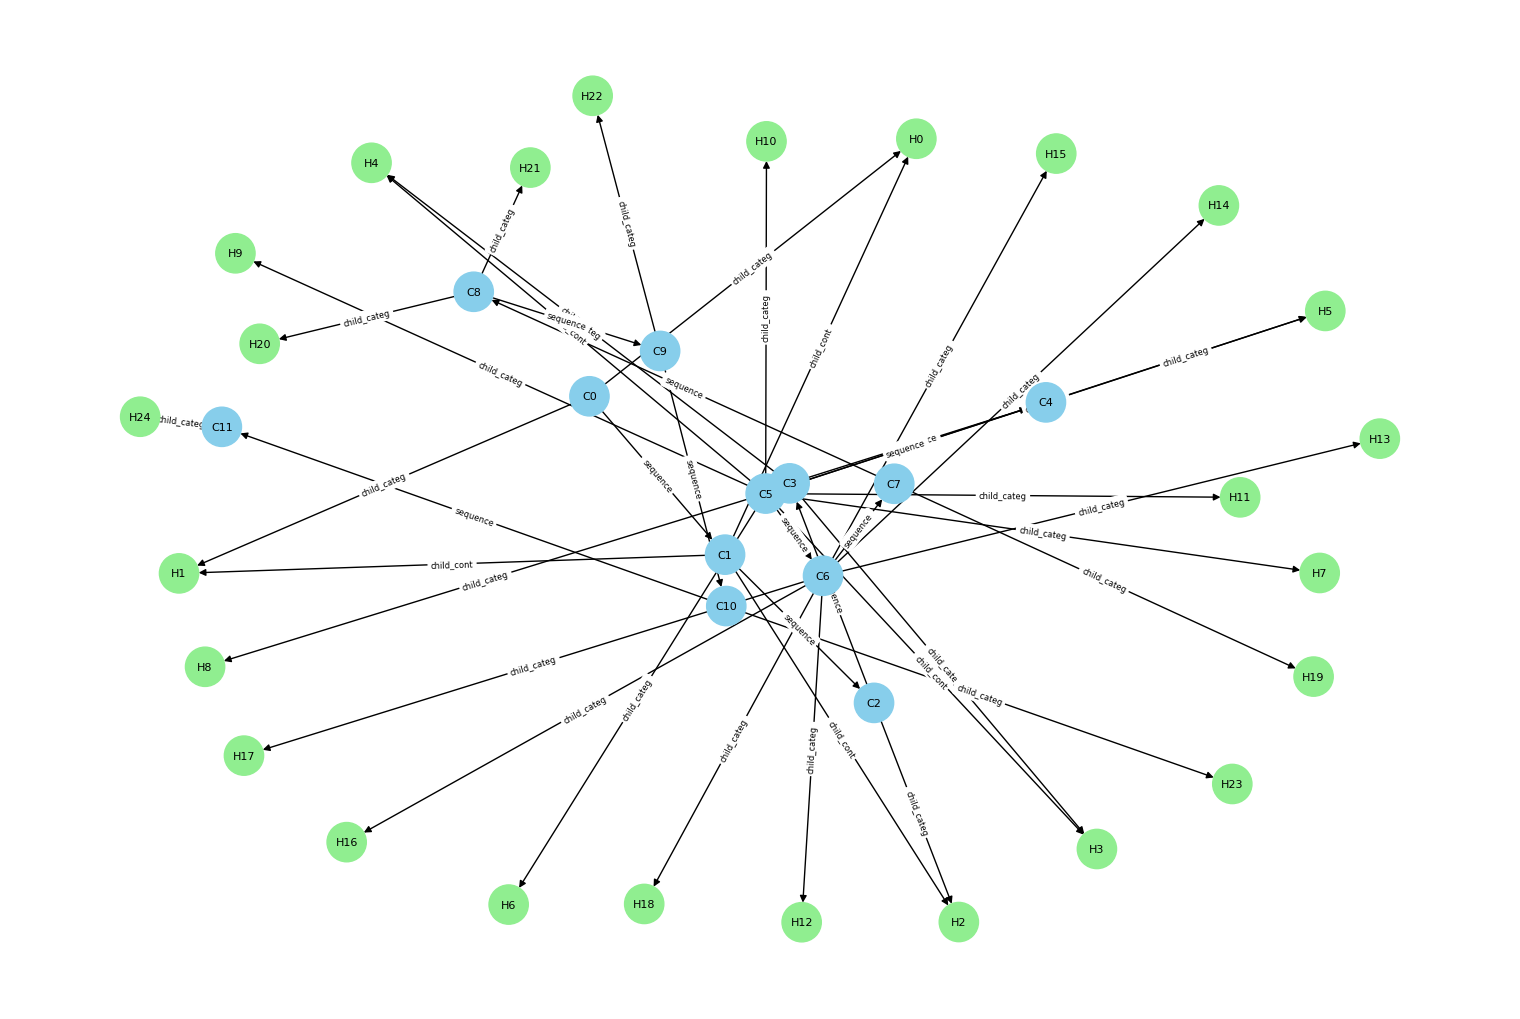

In [65]:
# Plot previous graph
G = hetero_to_networkx(pat_data_graph)

# Draw with colors by node type
color_map = ["skyblue" if G.nodes[n]["type"] == "central" else "lightgreen" for n in G.nodes]
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800, font_size=8)
edge_labels = nx.get_edge_attributes(G, "type")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

In [112]:
def build_hetero_graph_without_embeddings(
                                        pat_data_dict_regrouped,
                                        ids_ent_attr_pairs,
                                        continuous_ent_attr_pairs,
                                        categorical_ent_attr_pairs
                                      ):
    """
        Returns a Pytorch Geometric heterogeneous data representing
        the patient trajectory.

        Parameters:
        -----------
        pat_data_dict_regrouped: dict
            Dictionary regrouping the patient's features by date 
            (the keys are the times of measurments of patient
            information).
        ids_ent_attr_pairs: dict
            Dictionary giving unique IDs to pairs (entity, attribute),
            necessary to use embeddings. The keys are (entity, attribute)
            pairs and the values are the IDs.
        continuous_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having continuous (float) values.
        categorical_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having categorical values.

        Returns:
        --------
        pat_data_graph: HeteroData
            Heterogeneous graph representing the patient's trajectory.
    """
    # Creating graph Pytorch Geometric structure for patient
    pat_data_graph = HeteroData()
    
    # Central nodes (time feature only, float)
    central_nodes = torch.from_numpy(np.unique([int(pat_data_dict_regrouped[key][i]['days_since_tpx']) for key in pat_data_dict_regrouped for i in range(len(pat_data_dict_regrouped[key]))]).reshape(-1, 1))
    pat_data_graph["central"].x = central_nodes
    
    # Child nodes IDs and values
    children_ent_attr_continuous_ids = []
    children_ent_attr_continuous_values = []
    children_ent_attr_continuous_times = []
    children_ent_attr_continuous_days_since_tpx = []
    children_ent_attr_categorical_ids = []
    children_ent_attr_categorical_values = []
    children_ent_attr_categorical_times = []
    children_ent_attr_categorical_days_since_tpx = []
    for day in pat_data_dict_regrouped:
        n_childs = len(pat_data_dict_regrouped[day])
        for child_local_ID in range(n_childs):
            # Getting the child entity-attribute ID
            child = pat_data_dict_regrouped[day][child_local_ID]
            ent_attr_pair = (child['entity'], child['attribute'])
            id_ent_attr_pair = ids_ent_attr_pairs[ent_attr_pair]
    
            # Getting the value
            if (ent_attr_pair in continuous_ent_attr_pairs):
                children_ent_attr_continuous_ids.append(id_ent_attr_pair)
                children_ent_attr_continuous_values.append(float(child['value']))
                children_ent_attr_continuous_times.append(child['time'])
                children_ent_attr_continuous_days_since_tpx.append(child['days_since_tpx'])
            elif (ent_attr_pair in categorical_ent_attr_pairs):
                children_ent_attr_categorical_ids.append(id_ent_attr_pair)
                children_ent_attr_categorical_values.append([ent_attr_pair, child['value']])
                children_ent_attr_categorical_times.append(child['time'])
                children_ent_attr_categorical_days_since_tpx.append(child['days_since_tpx'])
    
                
    children_ent_attr_continuous_ids = torch.tensor(children_ent_attr_continuous_ids)
    children_ent_attr_continuous_values = torch.tensor(children_ent_attr_continuous_values)
    children_ent_attr_continuous_days_since_tpx = torch.tensor(children_ent_attr_continuous_days_since_tpx)
    children_ent_attr_categorical_ids = torch.tensor(children_ent_attr_categorical_ids)
    children_ent_attr_categorical_vocab_ids = torch.stack([torch.tensor(categorical_vals_vocabs[c[0]].get(c[1], categorical_vals_vocabs[c[0]]["<UNK>"])) for c in children_ent_attr_categorical_values])
    children_ent_attr_categorical_days_since_tpx = torch.tensor(children_ent_attr_categorical_days_since_tpx)
    
    # Child node features
    # Continuous
    pat_data_graph['child_cont'].ent_attr_ids = children_ent_attr_continuous_ids
    pat_data_graph['child_cont'].vals = children_ent_attr_continuous_values # .values cannot be used as it is already used by Pytorch Geometric
    pat_data_graph['child_cont'].days_since_tpx = children_ent_attr_continuous_days_since_tpx
    
    # Categorical
    pat_data_graph['child_categ'].ent_attr_ids = children_ent_attr_categorical_ids
    pat_data_graph['child_categ'].vocab_ids = children_ent_attr_categorical_vocab_ids
    pat_data_graph['child_categ'].days_since_tpx = children_ent_attr_categorical_days_since_tpx
    
    # Create the edges
    # Between central nodes
    central_nodes_edge_idx = torch.tensor([ [i for i in range(len(central_nodes)-1)], [j for j in range(1, len(central_nodes))]])
    central_nodes_times = [key for key in pat_data_dict_regrouped]
    edges_central_nodes_edge_attr = torch.tensor([date_difference_in_days(central_nodes_times[i], central_nodes_times[i+1]) for i in range(len(central_nodes_times)-1)]).unsqueeze(1)
    pat_data_graph["central", "sequence", "central"].edge_index = central_nodes_edge_idx
    pat_data_graph["central", "sequence", "central"].edge_attr = edges_central_nodes_edge_attr
    # Between central nodes and child nodes
    central_to_child_cont_edge_idx = [[], []]
    central_to_child_categ_edge_idx = [[], []]
    for central_node_i in range(central_nodes.shape[0]):
        time_central_node = central_nodes_times[central_node_i]
        # Continuous nodes
        for child_cont_j in range(len(children_ent_attr_continuous_times)):
            time_child_cont = children_ent_attr_continuous_times[child_cont_j]
            if (time_central_node == time_child_cont):
                central_to_child_cont_edge_idx[0].append(central_node_i)
                central_to_child_cont_edge_idx[1].append(child_cont_j)
        # Categorical nodes
        for child_categ_j in range(len(children_ent_attr_categorical_times)):
            time_child_categ = children_ent_attr_categorical_times[child_categ_j]
            if (time_central_node == time_child_categ):
                central_to_child_categ_edge_idx[0].append(central_node_i)
                central_to_child_categ_edge_idx[1].append(child_categ_j)
    central_to_child_cont_edge_idx = torch.tensor(central_to_child_cont_edge_idx)
    central_to_child_categ_edge_idx = torch.tensor(central_to_child_categ_edge_idx)
    pat_data_graph["central", "has_child", "child_cont"].edge_index = central_to_child_cont_edge_idx
    pat_data_graph["central", "has_child", "child_categ"].edge_index = central_to_child_categ_edge_idx

    return pat_data_graph
    
# Test
pat_data_graph_without_embeddings = build_hetero_graph_without_embeddings(
                                                                            pat_data_dict_regrouped=pat_data_dict_regrouped,
                                                                            ids_ent_attr_pairs=ids_ent_attr_pairs,
                                                                            continuous_ent_attr_pairs=continuous_ent_attr_pairs,
                                                                            categorical_ent_attr_pairs=categorical_ent_attr_pairs
                                                                          )


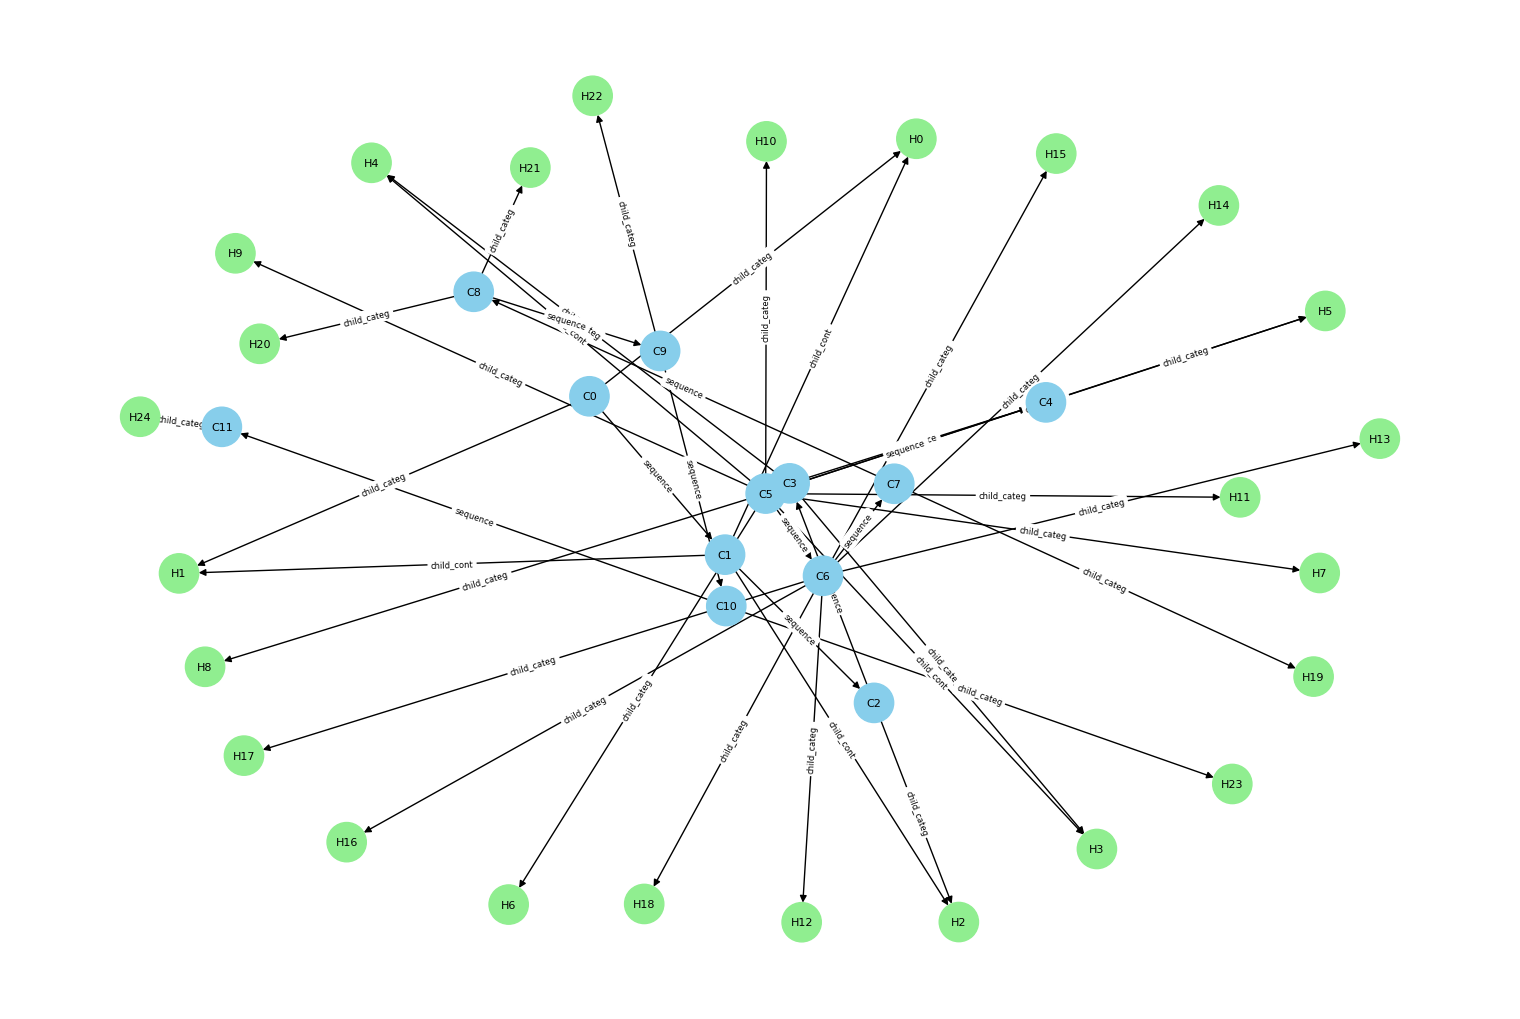

In [105]:
# Plot previous graph
G = hetero_to_networkx(pat_data_graph_without_embeddings)

# Draw with colors by node type
color_map = ["skyblue" if G.nodes[n]["type"] == "central" else "lightgreen" for n in G.nodes]
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800, font_size=8)
edge_labels = nx.get_edge_attributes(G, "type")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

In [142]:
class AiidkitTEAVGraphEmbedder(torch.nn.Module):
    def __init__(
                    self,
                    possible_values_all_patients,
                    categorical_ent_attr_pairs,
                    emb_dim_ent_attr=8,
                    emb_dim_ent_attr_vals=8
                ):
        """
            Model to get the embeddings of a TEAV AIIDKIT data representation, that
            can then be used with GNN models.
        """
        super().__init__()
        # Create IDs for all the entity-attribute pairs
        possible_ent_attr_pairs = list(possible_values_all_patients)
        ids_ent_attr_pairs = {possible_ent_attr_pairs[i]: i for i in range(len(possible_ent_attr_pairs))}
        self.inv_ids_ent_attr_pairs = {ids_ent_attr_pairs[ent_attr_pair]: ent_attr_pair for ent_attr_pair in ids_ent_attr_pairs}
        
        # Create embedding layer
        self.ent_attr_pair_emb_layer = torch.nn.Embedding(len(self.inv_ids_ent_attr_pairs), emb_dim_ent_attr)  # one embedding per entity-attr pair
        
        # Creating embedding layers for categorical values for entity-attribute pairs
        categorical_vals_vocabs = {}
        categorical_vals_emb_layers = {}
        for ent, attr in categorical_ent_attr_pairs:
            # Remove Unknown if exists
            categorical_ent_attr_pairs[(ent, attr)].discard('Unknown')
            categorical_ent_attr_pairs[(ent, attr)].discard('unknown')
            # Add Unknown token <UNK>
            categorical_ent_attr_pairs[(ent, attr)].add('<UNK>')
            categorical_vals_vocabs[(ent, attr)] = {value: index for index, value in enumerate(categorical_ent_attr_pairs[(ent, attr)])}
            tmp_ent = ent.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
            tmp_attr = attr.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
            categorical_vals_emb_layers[f"{tmp_ent}\\SEP\\{tmp_attr}"] = torch.nn.Embedding(len(categorical_vals_vocabs[(ent, attr)]), emb_dim_ent_attr_vals)
        self.categorical_vals_emb_layers = torch.nn.ModuleDict(categorical_vals_emb_layers)


    def forward(self, pat_data_graph):
        
        # Child node features
        # Continuous
        if (len(pat_data_graph['child_cont'].vals.shape) == 1): # Not batched input
            pat_data_graph['child_cont'].vals = pat_data_graph['child_cont'].vals.unsqueeze(0)
            pat_data_graph['child_cont'].ent_attr_ids = pat_data_graph['child_cont'].ent_attr_ids.unsqueeze(0)
        ent_attr_pair_cont_emb = self.ent_attr_pair_emb_layer(pat_data_graph['child_cont'].ent_attr_ids)
        ent_attr_pair_cont_emb = torch.cat([ent_attr_pair_cont_emb, pat_data_graph['child_cont'].vals.unsqueeze(-1)], dim=-1)
        pos_enc_cont_emb = positional_encoding(pos=pat_data_graph['child_cont'].days_since_tpx, d=ent_attr_pair_cont_emb.shape[2])
        child_cont_features = ent_attr_pair_cont_emb + pos_enc_cont_emb
        
        # Categorical
        ent_attr_pair_categ_emb = self.ent_attr_pair_emb_layer(pat_data_graph['child_categ'].ent_attr_ids)
        if (len(pat_data_graph['child_categ'].vocab_ids.shape) == 1): # Not batched input
            pat_data_graph['child_categ'].vocab_ids = pat_data_graph['child_categ'].vocab_ids.unsqueeze(0)
            pat_data_graph['child_categ'].ent_attr_ids = pat_data_graph['child_categ'].ent_attr_ids.unsqueeze(0)
        bs, n = pat_data_graph['child_categ'].vocab_ids.shape
        children_ent_attr_categorical_emb = []
        for i in range(bs):
            batch_out = []
            for j in range(n):
                vocab_id = pat_data_graph['child_categ'].vocab_ids[i, j]
                tmp_ent, tmp_attr = self.inv_ids_ent_attr_pairs[int(pat_data_graph['child_categ'].ent_attr_ids[i, j])]
                tmp_ent = tmp_ent.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
                tmp_attr = tmp_attr.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
                emb_layer_name = f"{tmp_ent}\\SEP\\{tmp_attr}"
                batch_out.append(self.categorical_vals_emb_layers[emb_layer_name](vocab_id))
            batch_out = torch.stack(batch_out)
            children_ent_attr_categorical_emb.append(batch_out)
        children_ent_attr_categorical_emb = torch.stack(children_ent_attr_categorical_emb)
        ent_attr_pair_categ_emb = ent_attr_pair_categ_emb + children_ent_attr_categorical_emb
        pos_enc_categ_emb = positional_encoding(pos=pat_data_graph['child_categ'].days_since_tpx, d=ent_attr_pair_categ_emb.shape[2])
        child_categ_features = ent_attr_pair_categ_emb + pos_enc_categ_emb

        return child_cont_features, child_categ_features


# Test
# Create model
graph_embedder = AiidkitTEAVGraphEmbedder(
                                            possible_values_all_patients=possible_values_all_patients,
                                            categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                            emb_dim_ent_attr=8,
                                            emb_dim_ent_attr_vals=8
                                         )
# Get features
child_cont_features, child_categ_features = graph_embedder(pat_data_graph_without_embeddings)
print(f"\n\n =========> Shape of the continuous features: {child_cont_features.shape}\n\t===> Shape of the categorical features: {child_categ_features.shape}\n\n")
# Cannot compare the values with those obtained with build_hetero_graph_with_embeddings
# as they do not have the same emebdding layers (different weights), only the shapes should match



 =========> Shape of the continuous features: torch.Size([1, 6, 9])
	===> Shape of the categorical features: torch.Size([1, 25, 8])




In [24]:
# IMPORTANT TODO: TEST THE PREVIOUS MODELS ON BATCHED EXAMPLES

### B) Create the graphs dataset

In [ ]:
# TODO

### IV) Model creation

In [ ]:
# TODO

## V) Train a simple GNN 

In [37]:
# URGENT HIGH PRIORITY: DURING TRAINING DO NOT FORGET TO ADD TO THE OPTIMIZER THE PARAMETERS OF THE EMBEDDING LAYER AND TRAIN IT !